In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

# Set display options
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
# Load data
df = pd.read_csv('TMDB_movie_dataset_v11.csv')
print(f"Initial dataset shape: {df.shape}")
df.head()

Initial dataset shape: (1288054, 24)


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.36,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.95,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.42,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.24,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.51,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.64,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.57,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.93,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.71,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.08,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [3]:
# Data cleaning - drop unnecessary columns
columns_to_drop = ['id', 'title', 'status', 'release_date', 'adult', 'backdrop_path', 
                   'homepage', 'imdb_id', 'original_language', 'original_title', 
                   'overview', 'poster_path', 'tagline', 'production_companies', 
                   'production_countries', 'spoken_languages', 'keywords']

df = df.drop(columns_to_drop, axis=1)

# Remove rows with missing values and zeros (which would cause issues with log transformation)
df = df.dropna()
df = df.loc[(df != 0).all(axis=1)]

print(f"Cleaned dataset shape: {df.shape}")
print(f"No missing values: {not df.isnull().any().any()}")

Cleaned dataset shape: (10383, 7)
No missing values: True


In [4]:
# Extract first genre
df['genres'] = df['genres'].str.split(',').str[0].str.strip()

# Display basic statistics
print("\nBasic Statistics (Before Log Transformation):")
df.describe()


Basic Statistics (Before Log Transformation):


,vote_average,vote_count,revenue,runtime,budget,popularity
count,"10,383.00","10,383.00","10,383.00","10,383.00","10,383.00","10,383.00"
mean,6.54,"1,472.89","64,562,337.72",105.19,"22,893,306.24",18.69
std,1.24,"2,937.37","154,660,833.03",35.75,"37,622,141.89",60.59
min,0.80,1.00,1.00,1.00,1.00,0.01
25%,5.88,51.00,"1,465,067.00",92.00,"1,706,398.00",5.61
50%,6.50,359.00,"11,900,000.00",104.00,"9,000,000.00",12.68
75%,7.13,"1,473.50","55,282,918.50",120.00,"26,000,000.00",20.14
max,10.00,"34,495.00","2,923,706,026.00",999.00,"460,000,000.00","2,994.36"


In [5]:
# Check skewness of numerical variables
print("\nSkewness of variables:")
numerical_cols = ['revenue', 'budget', 'vote_count', 'popularity', 'runtime', 'vote_average']
for col in numerical_cols:
    skew = df[col].skew()
    print(f"{col}: {skew:.2f}")


Skewness of variables:
revenue: 5.93
budget: 3.35
vote_count: 4.08
popularity: 29.35
runtime: 5.89
vote_average: 0.25


In [6]:
# Apply log transformation to highly skewed variables (skewness > 1)
# Creating log-transformed versions
df['log_revenue'] = np.log1p(df['revenue'])  # log1p handles zeros better
df['log_budget'] = np.log1p(df['budget'])
df['log_vote_count'] = np.log1p(df['vote_count'])
df['log_popularity'] = np.log1p(df['popularity'])

print("\nSkewness after log transformation:")
log_cols = ['log_revenue', 'log_budget', 'log_vote_count', 'log_popularity']
for col in log_cols:
    skew = df[col].skew()
    print(f"{col}: {skew:.2f}")


Skewness after log transformation:
log_revenue: -1.71
log_budget: -2.11
log_vote_count: -0.49
log_popularity: -0.20


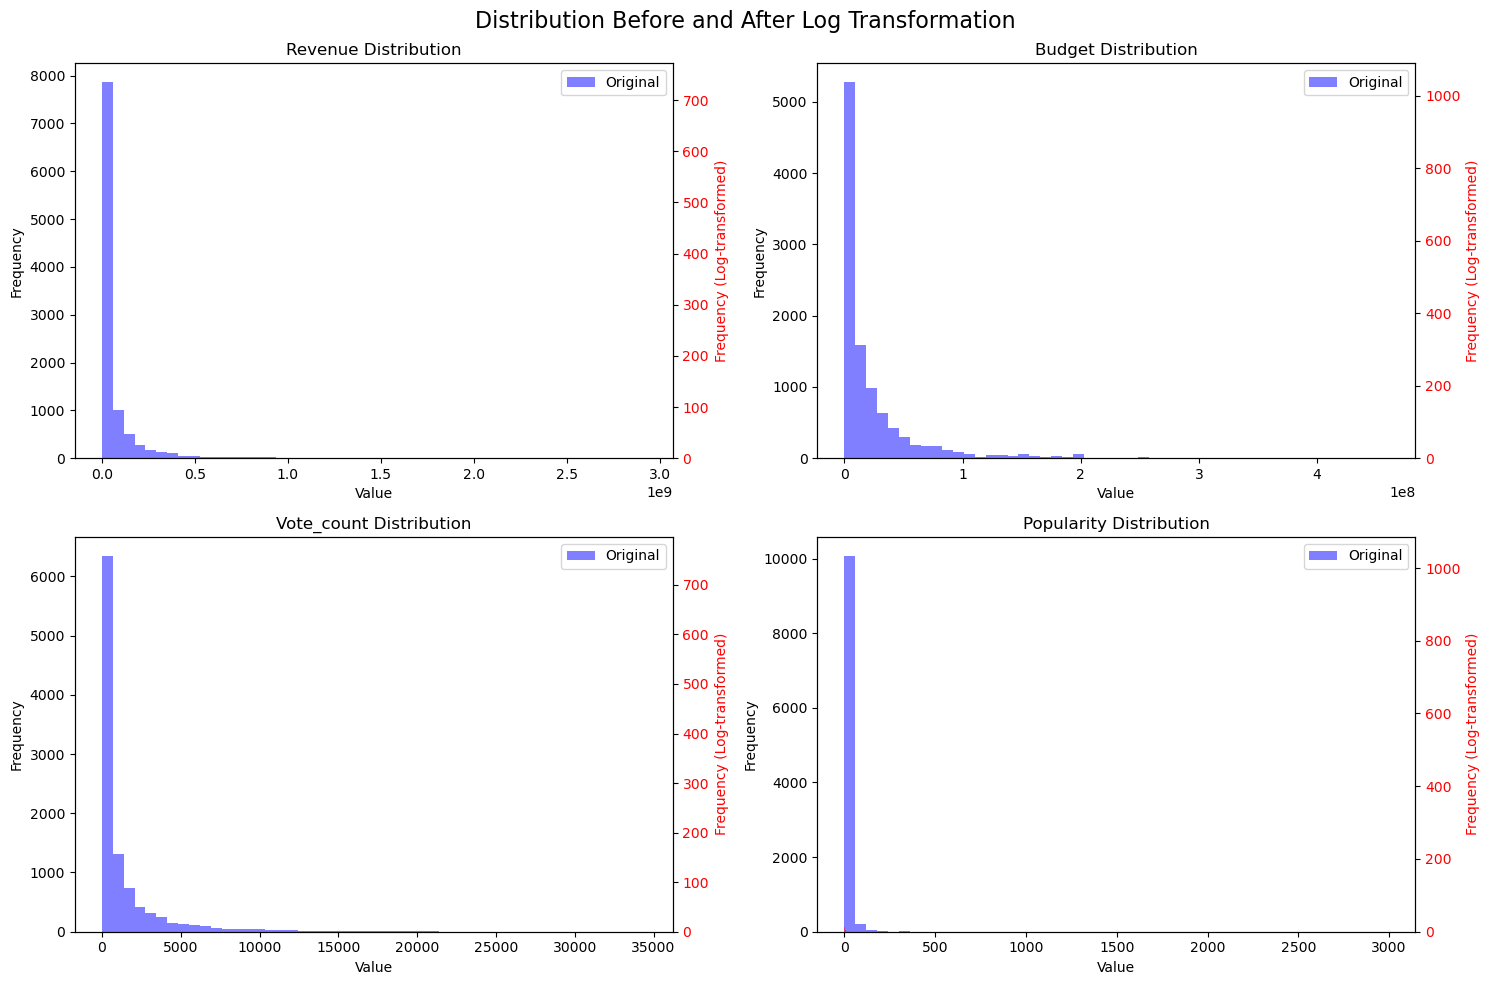

In [7]:
# Visualization: Distribution comparison before and after log transformation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Before and After Log Transformation', fontsize=16)

variables = [('revenue', 'log_revenue'), ('budget', 'log_budget'), 
             ('vote_count', 'log_vote_count'), ('popularity', 'log_popularity')]

for idx, (original, transformed) in enumerate(variables):
    row = idx // 2
    col = idx % 2
    
    # Original distribution
    axes[row, col].hist(df[original], bins=50, alpha=0.5, label='Original', color='blue')
    axes[row, col].set_title(f'{original.capitalize()} Distribution')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
    
    # Add transformed distribution on secondary axis
    ax2 = axes[row, col].twinx()
    ax2.hist(df[transformed], bins=50, alpha=0.5, label='Log-transformed', color='red')
    ax2.set_ylabel('Frequency (Log-transformed)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

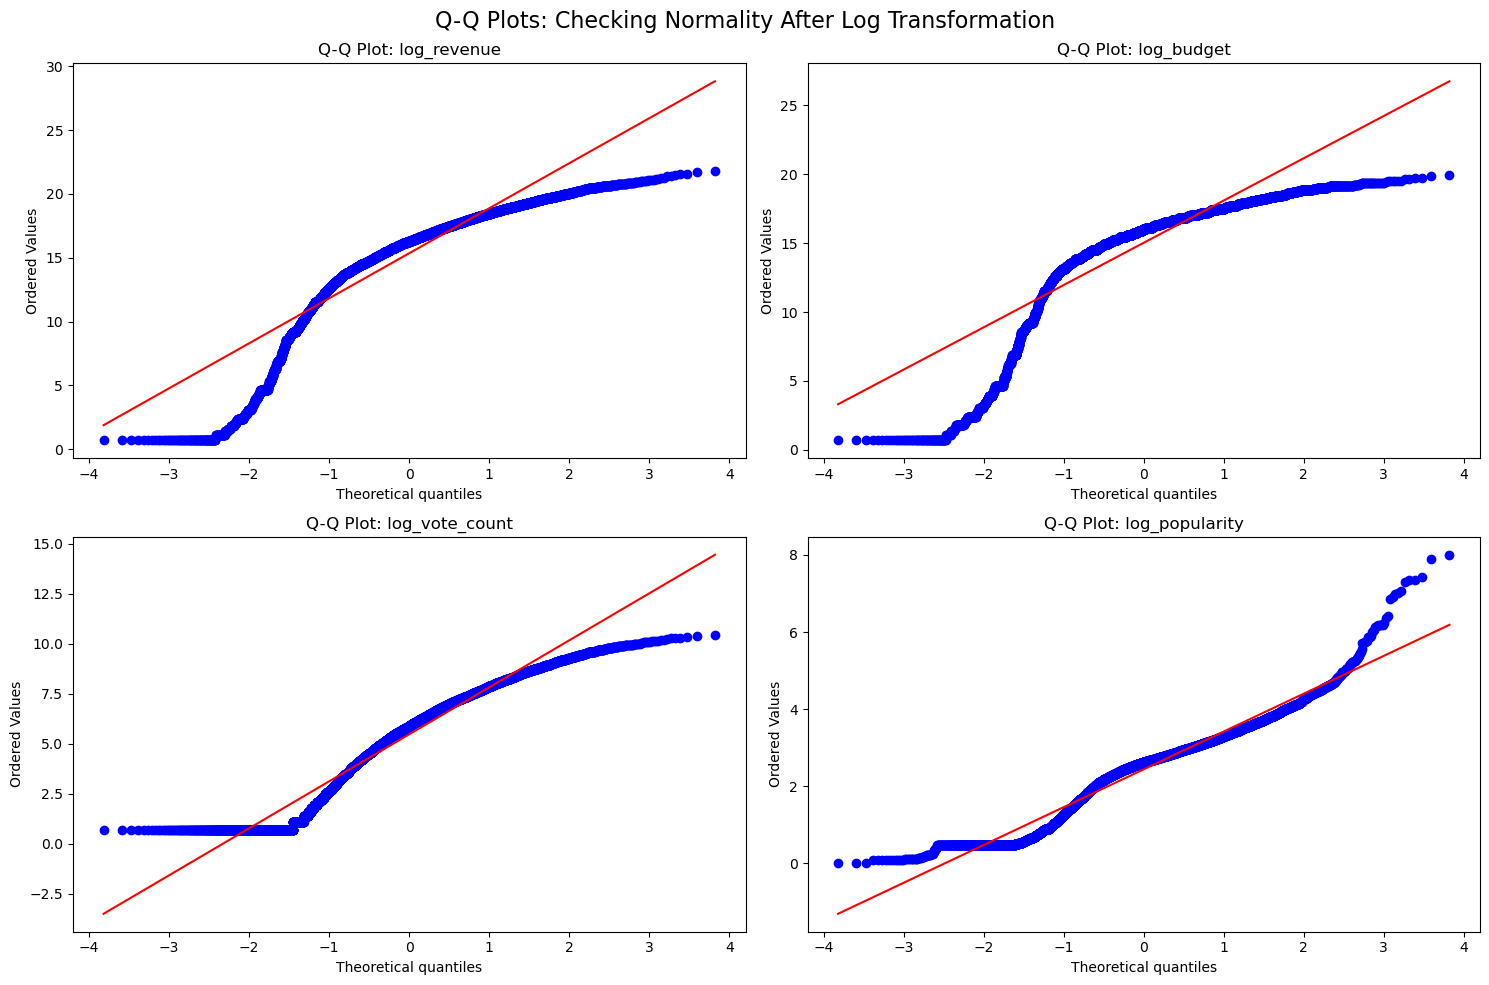

In [8]:
# Q-Q plots to check normality
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Q-Q Plots: Checking Normality After Log Transformation', fontsize=16)

for idx, col in enumerate(log_cols):
    row = idx // 2
    col_idx = idx % 2
    stats.probplot(df[col], dist="norm", plot=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Q-Q Plot: {col}')

plt.tight_layout()
plt.show()


Top 10 Genres by Average Log Revenue:
genres
Adventure                        16.82
Fantasy                          16.67
Family                           16.56
Animation                        16.40
Science Fiction                  16.19
Action                           16.05
Comedy                           15.50
War                              15.42
Crime                            15.39
History                          15.28
Name: log_revenue, dtype: float64


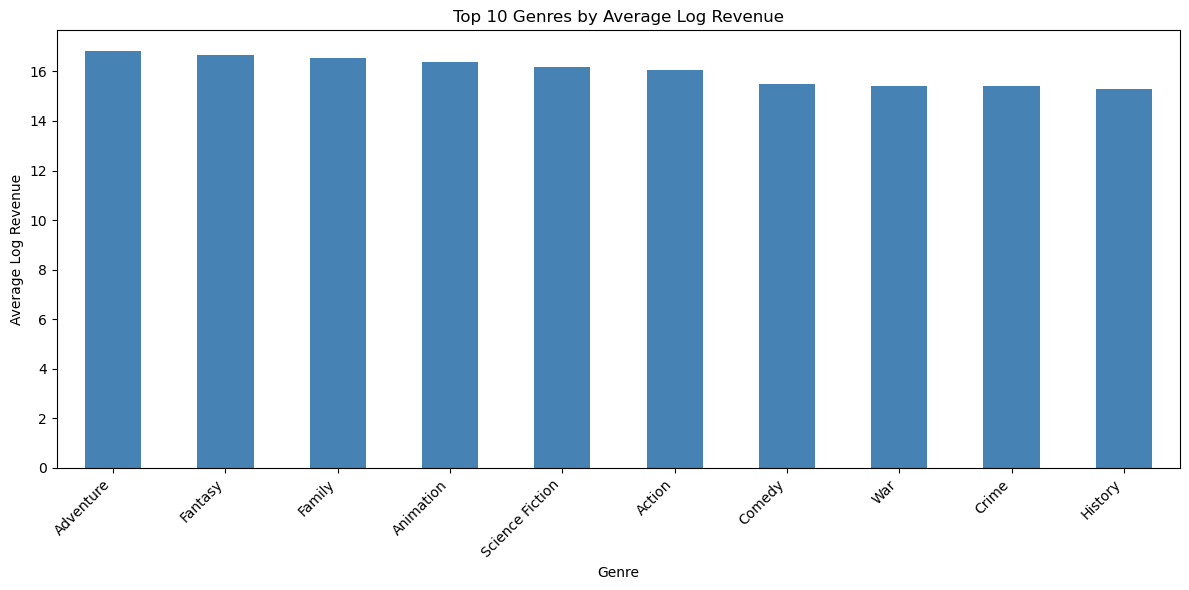

In [9]:
# Genre analysis with log-transformed revenue
print("\nTop 10 Genres by Average Log Revenue:")
genre_revenue = df.groupby('genres')['log_revenue'].mean().sort_values(ascending=False).head(10)
print(genre_revenue)

# Visualize
plt.figure(figsize=(12, 6))
genre_revenue.plot(kind='bar', color='steelblue')
plt.title('Top 10 Genres by Average Log Revenue')
plt.xlabel('Genre')
plt.ylabel('Average Log Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Correlation analysis with log-transformed variables
print("\nCorrelation with Log Revenue:")
correlation_vars = ['log_budget', 'log_popularity', 'log_vote_count', 'runtime', 'vote_average']
for var in correlation_vars:
    corr = df['log_revenue'].corr(df[var])
    print(f"{var}: {corr:.4f}")


Correlation with Log Revenue:
log_budget: 0.8576
log_popularity: 0.7275
log_vote_count: 0.7588
runtime: 0.4244
vote_average: -0.1764


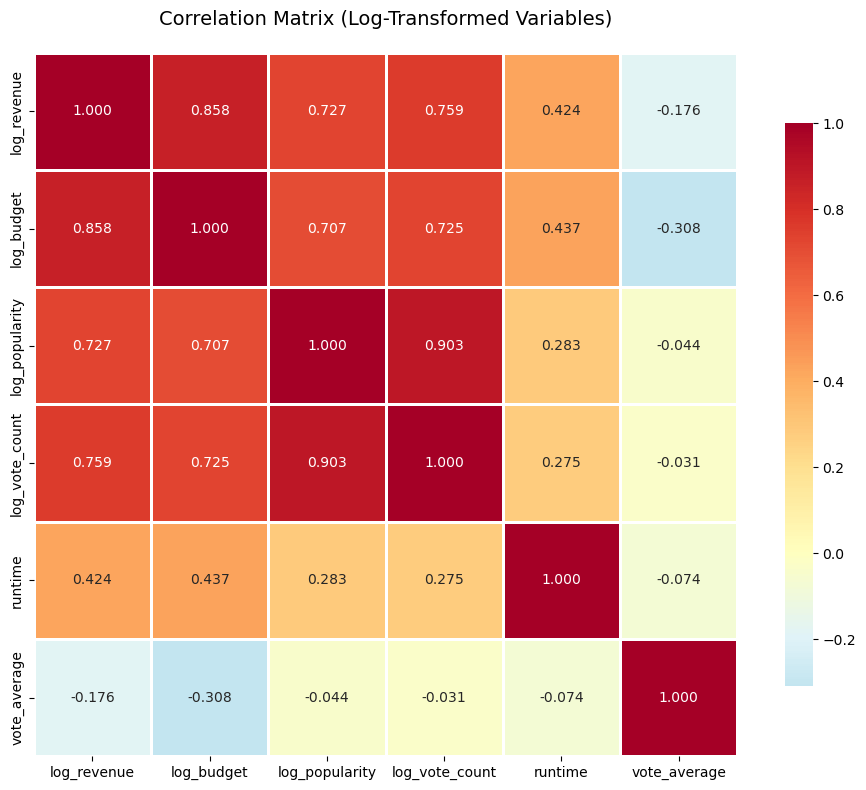

In [11]:
# Enhanced correlation heatmap
plt.figure(figsize=(10, 8))
correlation_cols = ['log_revenue', 'log_budget', 'log_popularity', 'log_vote_count', 'runtime', 'vote_average']
correlation_matrix = df[correlation_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Log-Transformed Variables)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [12]:
# Multiple linear regression with log-transformed variables
X = df[['log_budget', 'log_popularity', 'log_vote_count', 'runtime', 'vote_average']]
X = sm.add_constant(X)  # Add intercept
y = df['log_revenue']

model = sm.OLS(y, X)
results = model.fit()

print("\nLinear Regression Results (Log-Transformed Variables):")
print(results.summary())


Linear Regression Results (Log-Transformed Variables):
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     7396.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:03:50   Log-Likelihood:                -20801.
No. Observations:               10383   AIC:                         4.161e+04
Df Residuals:                   10377   BIC:                         4.166e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

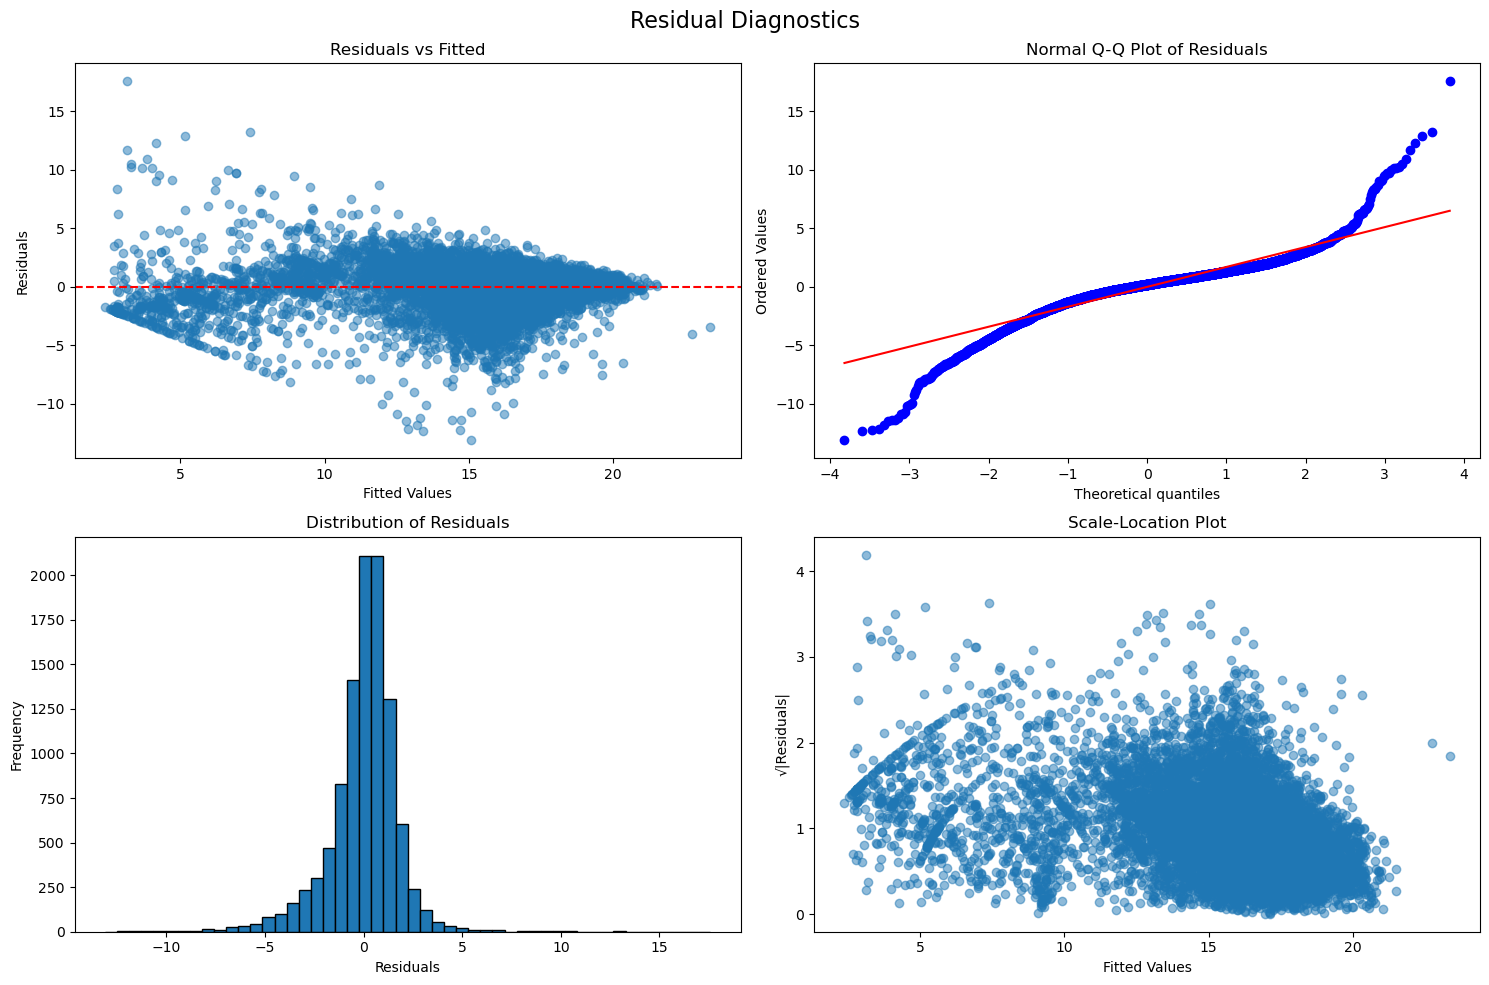

In [13]:
# Residual analysis
residuals = results.resid
fitted_values = results.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Residual Diagnostics', fontsize=16)

# Residuals vs Fitted
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')

# Q-Q plot of residuals
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot of Residuals')

# Histogram of residuals
axes[1, 0].hist(residuals, bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

# Scale-Location plot
axes[1, 1].scatter(fitted_values, np.sqrt(np.abs(residuals)), alpha=0.5)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Residuals|')
axes[1, 1].set_title('Scale-Location Plot')

plt.tight_layout()
plt.show()

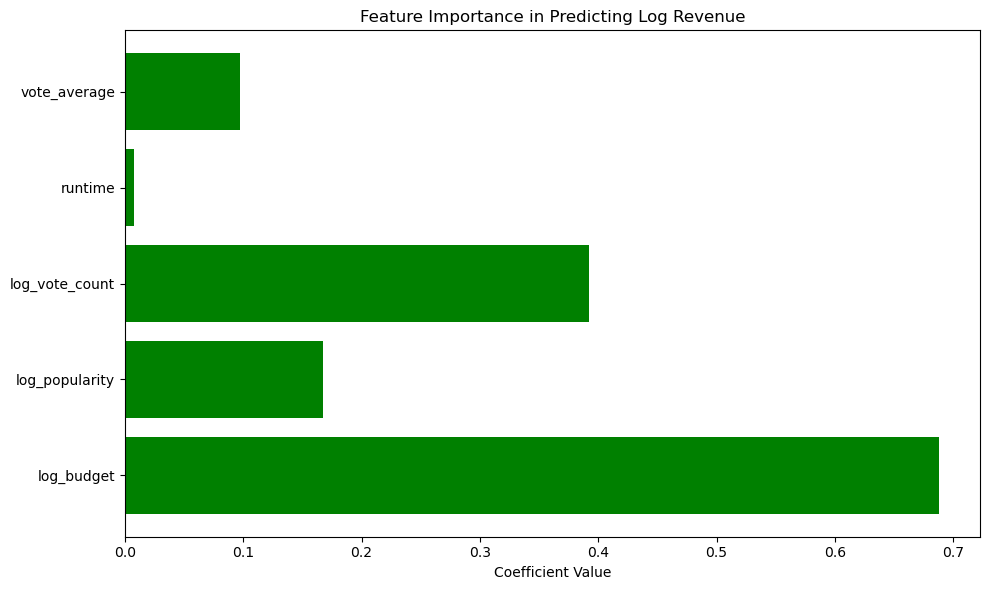

In [14]:
# Feature importance visualization
coefficients = results.params[1:]  # Exclude intercept
feature_names = ['log_budget', 'log_popularity', 'log_vote_count', 'runtime', 'vote_average']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color=['green' if x > 0 else 'red' for x in coefficients])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Predicting Log Revenue')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [15]:
# Model performance metrics
print("\nModel Performance Metrics:")
print(f"R-squared: {results.rsquared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")
print(f"RMSE: {np.sqrt(results.mse_resid):.4f}")

# Variance Inflation Factor (VIF) to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = feature_names
vif_data["VIF"] = [variance_inflation_factor(X.values, i+1) for i in range(len(feature_names))]
print("\nVariance Inflation Factors:")
print(vif_data)


Model Performance Metrics:
R-squared: 0.7809
Adjusted R-squared: 0.7808
AIC: 41614.98
BIC: 41658.47
RMSE: 1.7946

Variance Inflation Factors:
          Feature                  VIF
0      log_budget                 3.02
1  log_popularity                 5.58
2  log_vote_count                 6.06
3         runtime                 1.25
4    vote_average                 1.22


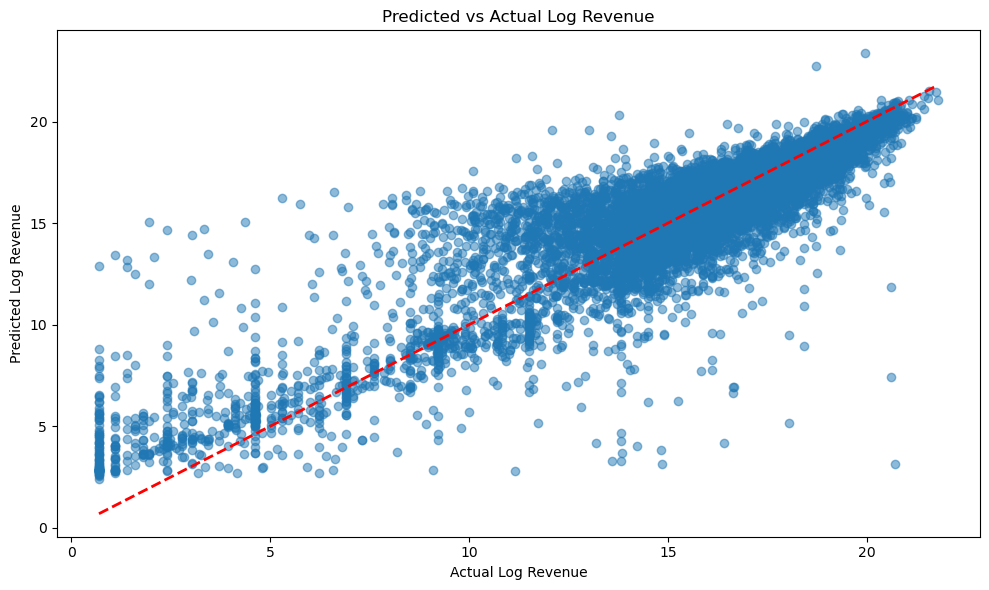

In [16]:
# Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y, fitted_values, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Log Revenue')
plt.ylabel('Predicted Log Revenue')
plt.title('Predicted vs Actual Log Revenue')
plt.tight_layout()
plt.show()

In [17]:
# Back-transform to original scale for interpretation
# Note: This is approximate due to log transformation bias
df['predicted_revenue'] = np.expm1(fitted_values)
df['actual_revenue'] = df['revenue']

print("\nSample Predictions (Back-transformed to Original Scale):")
comparison = df[['actual_revenue', 'predicted_revenue']].head(10)
comparison['error_percentage'] = ((comparison['predicted_revenue'] - comparison['actual_revenue']) / comparison['actual_revenue'] * 100)
print(comparison)


Sample Predictions (Back-transformed to Original Scale):
   actual_revenue    predicted_revenue     error_percentage
0       825532764     1,091,556,243.87                32.22
1       701729206     1,405,865,242.46               100.34
2      1004558444     1,296,457,939.50                29.06
3      2923706026     1,384,566,739.12               -52.64
4      1518815515     1,178,271,207.29               -22.42
5       783100000       336,143,705.10               -57.08
6      2052415039     1,703,061,475.53               -17.02
7       100853753       476,775,274.01               372.74
8       772776600       684,213,923.62               -11.46
9       213900000       134,740,115.66               -37.01


In [18]:
# Summary of findings
print("\n" + "="*80)
print("SUMMARY OF KEY FINDINGS")
print("="*80)

print("\n1. DATA TRANSFORMATION:")
print("   - Applied log transformation to highly skewed variables (revenue, budget, vote_count, popularity)")
print("   - Significantly reduced skewness and improved model assumptions")

print("\n2. CORRELATION INSIGHTS (Log-transformed):")
correlation_summary = df[['log_revenue', 'log_budget', 'log_vote_count', 'log_popularity']].corr()['log_revenue'].sort_values(ascending=False)
print(correlation_summary[1:])

print("\n3. MODEL PERFORMANCE:")
print(f"   - R-squared: {results.rsquared:.4f} (explains {results.rsquared*100:.1f}% of variance)")
print(f"   - All predictors are statistically significant (p < 0.05)")

print("\n4. KEY PREDICTORS OF REVENUE:")
coef_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients.values,
    'Abs_Coefficient': np.abs(coefficients.values)
}).sort_values('Abs_Coefficient', ascending=False)
print(coef_importance[['Feature', 'Coefficient']])

print("\n5. RECOMMENDATIONS:")
print("   - Budget and vote count are strong positive predictors of revenue")
print("   - Popularity shows positive correlation after log transformation")
print("   - Runtime has negative association - consider optimal movie length")
print("   - The log-log model provides better fit and interpretability")


SUMMARY OF KEY FINDINGS

1. DATA TRANSFORMATION:
   - Applied log transformation to highly skewed variables (revenue, budget, vote_count, popularity)
   - Significantly reduced skewness and improved model assumptions

2. CORRELATION INSIGHTS (Log-transformed):
log_budget                       0.86
log_vote_count                   0.76
log_popularity                   0.73
Name: log_revenue, dtype: float64

3. MODEL PERFORMANCE:
   - R-squared: 0.7809 (explains 78.1% of variance)
   - All predictors are statistically significant (p < 0.05)

4. KEY PREDICTORS OF REVENUE:
          Feature          Coefficient
0      log_budget                 0.69
2  log_vote_count                 0.39
1  log_popularity                 0.17
4    vote_average                 0.10
3         runtime                 0.01

5. RECOMMENDATIONS:
   - Budget and vote count are strong positive predictors of revenue
   - Popularity shows positive correlation after log transformation
   - Runtime has negative assoc